In [2]:
import pandas as pd
import numpy as np
import io
from sklearn.utils import shuffle
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict 
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
#!pip install venn
from venn import venn
import csv
%matplotlib inline
import graphviz
import numexpr
import itertools
from subprocess import call
from sklearn import tree
from sklearn.metrics import fbeta_score
#!pip install umap-learn
import umap.umap_ as umap
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [ ]:
#######################################################################################################################
# Table analysis w/ gradings
#######################################################################################################################

with open('/project/gpaa/machine_learning/jainam_capstone/preprocessing/GPAA_AA_batches0-16_metadata.csv', 'r') as f:
  AA_metadata = pd.read_csv(f)

with open('/project/gpaa/machine_learning/jainam_capstone/preprocessing/GPAA_LAD_batches0-16_metadata.csv', 'r') as f:
  LAD_metadata = pd.read_csv(f)

'''
with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/confusion_matrix/NSF_XGB_confusion_AA.csv', 'r') as f:
  NSF_AA_results = pd.read_csv(f)
  NSF_AA_results = NSF_AA_results.to_records(index=False)
  NSF_AA_results = list(NSF_AA_results)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/confusion_matrix/NSF_XGB_confusion_LAD.csv', 'r') as f:
  NSF_LAD_results = pd.read_csv(f)
  NSF_LAD_results = NSF_LAD_results.to_records(index=False)
  NSF_LAD_results = list(NSF_LAD_results)
'''

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_random_forest_XGB_confusion_AA.csv', 'r') as f:
  random_forest_AA_results = pd.read_csv(f)
  random_forest_AA_results = random_forest_AA_results.to_records(index=False)
  random_forest_AA_results = list(random_forest_AA_results)

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_random_forest_XGB_confusion_LAD.csv', 'r') as f:
  random_forest_LAD_results = pd.read_csv(f)
  random_forest_LAD_results = random_forest_LAD_results.to_records(index=False)
  random_forest_LAD_results = list(random_forest_LAD_results)

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_RFE_XGB_confusion_AA.csv', 'r') as f:
  RFE_AA_results = pd.read_csv(f)
  RFE_AA_results = RFE_AA_results.to_records(index=False)
  RFE_AA_results = list(RFE_AA_results)

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_RFE_XGB_confusion_LAD.csv', 'r') as f:
  RFE_LAD_results = pd.read_csv(f)
  RFE_LAD_results = RFE_LAD_results.to_records(index=False)
  RFE_LAD_results = list(RFE_LAD_results)

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_LASSO_XGB_confusion_AA.csv', 'r') as f:
  LASSO_AA_results = pd.read_csv(f)
  LASSO_AA_results = LASSO_AA_results.to_records(index=False)
  LASSO_AA_results = list(LASSO_AA_results)

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_LASSO_XGB_confusion_LAD.csv', 'r') as f:
  LASSO_LAD_results = pd.read_csv(f)
  LASSO_LAD_results = LASSO_LAD_results.to_records(index=False)
  LASSO_LAD_results = list(LASSO_LAD_results)

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_union_XGB_confusion_AA.csv', 'r') as f:
  union_AA_results = pd.read_csv(f)
  union_AA_results = union_AA_results.to_records(index=False)
  union_AA_results = list(union_AA_results)

with open('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_old/holdout_union_XGB_confusion_LAD.csv', 'r') as f:
  union_LAD_results = pd.read_csv(f)
  union_LAD_results = union_LAD_results.to_records(index=False)
  union_LAD_results = list(union_LAD_results)


with open('/project/gpaa/machine_learning/metadata/GPAA_samples_batches0-16_metadata_detail_grading_2022_03_28.csv', 'r') as f:
  sample_qualities = pd.read_csv(f)
  sample_qualities = sample_qualities[['UVA_sample_id', 'pathology (assigned category)', 'type', ' patholgy_desc (LESION PRESENT'), 'Total Surface % ', ' Grade FS %', ' Grade FP %', ' Grade CO %', ' Grade CA %']]

'''
#(sample_id, LESION PRESENT, Total Surface %, Grade FS %,	Grade FP %,	Grade CO %,	Grade CA %)
#create pheaux gradings
for index, row in sample_qualities.iterrows():
  if row['type'] == 'L':
    sample_qualities.at[index, 'Total Surface % '] = 100
    if row['pathology'] == 'fc':
      sample_qualities.at[index, ' Grade CA %'] = 100

    elif row['pathology'] == 'fp':
      sample_qualities.at[index, ' Grade FP %'] = 100

    elif row['pathology'] == 'fs':
      sample_qualities.at[index, ' Grade FS %'] = 100

  elif row['type'] == 'NL':
    sample_qualities.at[index, 'Total Surface % '] = 0

sample_qualities = sample_qualities[sample_qualities['type'] != 'liver']

sample_qualities['%_fs'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade FS %'] / 100, axis = 1)
sample_qualities['%_fc'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade CA %'] / 100, axis = 1)
sample_qualities['%_fp'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade FP %'] / 100, axis = 1)
sample_qualities['weighted_%_fp'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade FP %'] / 200, axis = 1) # 200 means weighting factor is .5
sample_qualities['%_co'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade CO %'] / 100, axis = 1)
sample_qualities['%_severity'] = sample_qualities['Total Surface % '] * sample_qualities[['%_fc', '%_fp', '%_co']].sum(axis=1) / 100
sample_qualities['%_severity_weighted_fp'] = sample_qualities['Total Surface % '] * sample_qualities[['%_fc', '%_co', 'weighted_%_fp']].sum(axis=1) / 100
sample_qualities = sample_qualities.fillna(0)
print(sample_qualities.shape)
print(sample_qualities['%_severity'])
'''

In [3]:
# initialize dataframe - each row is a sample. start with AA, keeping constant sizes for all models
AA_confusion_table_size = pd.DataFrame(AA_metadata['sample_id'])

AA_confusion_table_size = AA_confusion_table_size.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', 'weighted_%_fp', '%_severity', '%_severity_weighted_fp']], on='sample_id')
print(AA_confusion_table_size.shape)
AA_confusion_table_size.head()

AA_confusion_table_size['size_3_TP'] = 0
AA_confusion_table_size['size_3_TN'] = 0
AA_confusion_table_size['size_3_FP'] = 0
AA_confusion_table_size['size_3_FN'] = 0
AA_confusion_table_size['size_6_TP'] = 0
AA_confusion_table_size['size_6_TN'] = 0
AA_confusion_table_size['size_6_FP'] = 0
AA_confusion_table_size['size_6_FN'] = 0
AA_confusion_table_size['size_9_TP'] = 0
AA_confusion_table_size['size_9_TN'] = 0
AA_confusion_table_size['size_9_FP'] = 0
AA_confusion_table_size['size_9_FN'] = 0
AA_confusion_table_size['size_12_TP'] = 0
AA_confusion_table_size['size_12_TN'] = 0
AA_confusion_table_size['size_12_FP'] = 0
AA_confusion_table_size['size_12_FN'] = 0
AA_confusion_table_size['size_15_TP'] = 0
AA_confusion_table_size['size_15_TN'] = 0
AA_confusion_table_size['size_15_FP'] = 0
AA_confusion_table_size['size_15_FN'] = 0
AA_confusion_table_size['size_18_TP'] = 0
AA_confusion_table_size['size_18_TN'] = 0
AA_confusion_table_size['size_18_FP'] = 0
AA_confusion_table_size['size_18_FN'] = 0
AA_confusion_table_size['size_21_TP'] = 0
AA_confusion_table_size['size_21_TN'] = 0
AA_confusion_table_size['size_21_FP'] = 0
AA_confusion_table_size['size_21_FN'] = 0
AA_confusion_table_size['size_24_TP'] = 0
AA_confusion_table_size['size_24_TN'] = 0
AA_confusion_table_size['size_24_FP'] = 0
AA_confusion_table_size['size_24_FN'] = 0
AA_confusion_table_size['size_27_TP'] = 0
AA_confusion_table_size['size_27_TN'] = 0
AA_confusion_table_size['size_27_FP'] = 0
AA_confusion_table_size['size_27_FN'] = 0
AA_confusion_table_size['size_30_TP'] = 0
AA_confusion_table_size['size_30_TN'] = 0
AA_confusion_table_size['size_30_FP'] = 0
AA_confusion_table_size['size_30_FN'] = 0
AA_confusion_table_size['size_60_TP'] = 0
AA_confusion_table_size['size_60_TN'] = 0
AA_confusion_table_size['size_60_FP'] = 0
AA_confusion_table_size['size_60_FN'] = 0
AA_confusion_table_size['size_90_TP'] = 0
AA_confusion_table_size['size_90_TN'] = 0
AA_confusion_table_size['size_90_FP'] = 0
AA_confusion_table_size['size_90_FN'] = 0
AA_confusion_table_size['size_120_TP'] = 0
AA_confusion_table_size['size_120_TN'] = 0
AA_confusion_table_size['size_120_FP'] = 0
AA_confusion_table_size['size_120_FN'] = 0
AA_confusion_table_size['size_150_TP'] = 0
AA_confusion_table_size['size_150_TN'] = 0
AA_confusion_table_size['size_150_FP'] = 0
AA_confusion_table_size['size_150_FN'] = 0
AA_confusion_table_size['size_180_TP'] = 0
AA_confusion_table_size['size_180_TN'] = 0
AA_confusion_table_size['size_180_FP'] = 0
AA_confusion_table_size['size_180_FN'] = 0
AA_confusion_table_size['size_210_TP'] = 0
AA_confusion_table_size['size_210_TN'] = 0
AA_confusion_table_size['size_210_FP'] = 0
AA_confusion_table_size['size_210_FN'] = 0
AA_confusion_table_size['size_240_TP'] = 0
AA_confusion_table_size['size_240_TN'] = 0
AA_confusion_table_size['size_240_FP'] = 0
AA_confusion_table_size['size_240_FN'] = 0

AA_confusion_table_size = AA_confusion_table_size.set_index('sample_id')

print(AA_confusion_table_size.shape)
AA_confusion_table_size.head()
#print(AA_confusion_table_size['%_severity'])

(242, 8)
(242, 75)


,%_fs,%_fc,%_co,%_fp,weighted_%_fp,%_severity,%_severity_weighted_fp,size_3_TP,size_3_TN,size_3_FP,size_3_FN,size_6_TP,size_6_TN,size_6_FP,size_6_FN,size_9_TP,size_9_TN,size_9_FP,size_9_FN,size_12_TP,size_12_TN,size_12_FP,size_12_FN,size_15_TP,size_15_TN,size_15_FP,size_15_FN,size_18_TP,size_18_TN,size_18_FP,size_18_FN,size_21_TP,size_21_TN,size_21_FP,size_21_FN,size_24_TP,size_24_TN,size_24_FP,size_24_FN,size_27_TP,size_27_TN,size_27_FP,size_27_FN,size_30_TP,size_30_TN,size_30_FP,size_30_FN,size_60_TP,size_60_TN,size_60_FP,size_60_FN,size_90_TP,size_90_TN,size_90_FP,size_90_FN,size_120_TP,size_120_TN,size_120_FP,size_120_FN,size_150_TP,size_150_TN,size_150_FP,size_150_FN,size_180_TP,size_180_TN,size_180_FP,size_180_FN,size_210_TP,size_210_TN,size_210_FP,size_210_FN,size_240_TP,size_240_TN,size_240_FP,size_240_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,0.0,100.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540-NL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540b-L,0.0,100.0,0.0,0.0,0.0,100.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540b-NL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1560-L,0.0,100.0,0.0,0.0,0.0,100.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
AA_results = [union_AA_results, LASSO_AA_results, RFE_AA_results, random_forest_AA_results, NSF_AA_results]


for result in AA_results:
  for record in result:
    col = 'size_'
    size = record[1].split('_')[-1]
    if int(size) == 4:
      size = 3
    if int(size) % 3 != 0:
      size = int(size)-1
    label = '_'+str(record[3])
    col = col+str(size)+label

    AA_confusion_table_size.at[record[4], col] = AA_confusion_table_size.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_size.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_size.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_size.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_size.columns if 'FN' in col]

AA_confusion_table_size['TP_%'] = AA_confusion_table_size.apply(lambda row: sum(row[tp_cols]) / 85, axis = 1)
AA_confusion_table_size['TN_%'] = AA_confusion_table_size.apply(lambda row: sum(row[tn_cols]) / 85, axis = 1)
AA_confusion_table_size['FP_%'] = AA_confusion_table_size.apply(lambda row: sum(row[fp_cols]) / 85, axis = 1)
AA_confusion_table_size['FN_%'] = AA_confusion_table_size.apply(lambda row: sum(row[fn_cols]) / 85, axis = 1)

AA_confusion_table_size = AA_confusion_table_size[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_size if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

print(AA_confusion_table_size.shape)
AA_confusion_table_size.head()

(242, 79)


,%_fs,%_fc,%_fp,%_co,TP_%,TN_%,FP_%,FN_%,weighted_%_fp,%_severity,%_severity_weighted_fp,size_3_TP,size_3_TN,size_3_FP,size_3_FN,size_6_TP,size_6_TN,size_6_FP,size_6_FN,size_9_TP,size_9_TN,size_9_FP,size_9_FN,size_12_TP,size_12_TN,size_12_FP,size_12_FN,size_15_TP,size_15_TN,size_15_FP,size_15_FN,size_18_TP,size_18_TN,size_18_FP,size_18_FN,size_21_TP,size_21_TN,size_21_FP,size_21_FN,size_24_TP,size_24_TN,size_24_FP,size_24_FN,size_27_TP,size_27_TN,size_27_FP,size_27_FN,size_30_TP,size_30_TN,size_30_FP,size_30_FN,size_60_TP,size_60_TN,size_60_FP,size_60_FN,size_90_TP,size_90_TN,size_90_FP,size_90_FN,size_120_TP,size_120_TN,size_120_FP,size_120_FN,size_150_TP,size_150_TN,size_150_FP,size_150_FN,size_180_TP,size_180_TN,size_180_FP,size_180_FN,size_210_TP,size_210_TN,size_210_FP,size_210_FN,size_240_TP,size_240_TN,size_240_FP,size_240_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,0.964706,0.000000,0.000000,0.035294,0.0,100.0,100.0,3,0,0,2,5,0,0,0,4,0,0,1,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0
c1540-NL,0.0,0.0,0.0,0.0,0.000000,0.976471,0.023529,0.000000,0.0,0.0,0.0,0,5,0,0,0,4,1,0,0,5,0,0,0,4,1,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0
c1540b-L,0.0,100.0,0.0,0.0,0.600000,0.000000,0.000000,0.400000,0.0,100.0,100.0,2,0,0,3,3,0,0,2,3,0,0,2,2,0,0,3,4,0,0,1,3,0,0,2,3,0,0,2,4,0,0,1,3,0,0,2,3,0,0,2,4,0,0,1,3,0,0,2,2,0,0,3,3,0,0,2,3,0,0,2,3,0,0,2,3,0,0,2
c1540b-NL,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0
c1560-L,0.0,100.0,0.0,0.0,0.964706,0.000000,0.000000,0.035294,0.0,100.0,100.0,3,0,0,2,4,0,0,1,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0


In [5]:
# initialize dataframe - each row is a sample. start with LAD, keeping constant sizes for all models
LAD_confusion_table_size = pd.DataFrame(LAD_metadata['sample_id'])

LAD_confusion_table_size = LAD_confusion_table_size.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', '%_severity']], on='sample_id')
print(LAD_confusion_table_size.shape)
LAD_confusion_table_size.head()

LAD_confusion_table_size['size_3_TP'] = 0
LAD_confusion_table_size['size_3_TN'] = 0
LAD_confusion_table_size['size_3_FP'] = 0
LAD_confusion_table_size['size_3_FN'] = 0
LAD_confusion_table_size['size_6_TP'] = 0
LAD_confusion_table_size['size_6_TN'] = 0
LAD_confusion_table_size['size_6_FP'] = 0
LAD_confusion_table_size['size_6_FN'] = 0
LAD_confusion_table_size['size_9_TP'] = 0
LAD_confusion_table_size['size_9_TN'] = 0
LAD_confusion_table_size['size_9_FP'] = 0
LAD_confusion_table_size['size_9_FN'] = 0
LAD_confusion_table_size['size_12_TP'] = 0
LAD_confusion_table_size['size_12_TN'] = 0
LAD_confusion_table_size['size_12_FP'] = 0
LAD_confusion_table_size['size_12_FN'] = 0
LAD_confusion_table_size['size_15_TP'] = 0
LAD_confusion_table_size['size_15_TN'] = 0
LAD_confusion_table_size['size_15_FP'] = 0
LAD_confusion_table_size['size_15_FN'] = 0
LAD_confusion_table_size['size_18_TP'] = 0
LAD_confusion_table_size['size_18_TN'] = 0
LAD_confusion_table_size['size_18_FP'] = 0
LAD_confusion_table_size['size_18_FN'] = 0
LAD_confusion_table_size['size_21_TP'] = 0
LAD_confusion_table_size['size_21_TN'] = 0
LAD_confusion_table_size['size_21_FP'] = 0
LAD_confusion_table_size['size_21_FN'] = 0
LAD_confusion_table_size['size_24_TP'] = 0
LAD_confusion_table_size['size_24_TN'] = 0
LAD_confusion_table_size['size_24_FP'] = 0
LAD_confusion_table_size['size_24_FN'] = 0
LAD_confusion_table_size['size_27_TP'] = 0
LAD_confusion_table_size['size_27_TN'] = 0
LAD_confusion_table_size['size_27_FP'] = 0
LAD_confusion_table_size['size_27_FN'] = 0
LAD_confusion_table_size['size_30_TP'] = 0
LAD_confusion_table_size['size_30_TN'] = 0
LAD_confusion_table_size['size_30_FP'] = 0
LAD_confusion_table_size['size_30_FN'] = 0
LAD_confusion_table_size['size_60_TP'] = 0
LAD_confusion_table_size['size_60_TN'] = 0
LAD_confusion_table_size['size_60_FP'] = 0
LAD_confusion_table_size['size_60_FN'] = 0
LAD_confusion_table_size['size_90_TP'] = 0
LAD_confusion_table_size['size_90_TN'] = 0
LAD_confusion_table_size['size_90_FP'] = 0
LAD_confusion_table_size['size_90_FN'] = 0
LAD_confusion_table_size['size_120_TP'] = 0
LAD_confusion_table_size['size_120_TN'] = 0
LAD_confusion_table_size['size_120_FP'] = 0
LAD_confusion_table_size['size_120_FN'] = 0
LAD_confusion_table_size['size_150_TP'] = 0
LAD_confusion_table_size['size_150_TN'] = 0
LAD_confusion_table_size['size_150_FP'] = 0
LAD_confusion_table_size['size_150_FN'] = 0
LAD_confusion_table_size['size_180_TP'] = 0
LAD_confusion_table_size['size_180_TN'] = 0
LAD_confusion_table_size['size_180_FP'] = 0
LAD_confusion_table_size['size_180_FN'] = 0
LAD_confusion_table_size['size_210_TP'] = 0
LAD_confusion_table_size['size_210_TN'] = 0
LAD_confusion_table_size['size_210_FP'] = 0
LAD_confusion_table_size['size_210_FN'] = 0
LAD_confusion_table_size['size_240_TP'] = 0
LAD_confusion_table_size['size_240_TN'] = 0
LAD_confusion_table_size['size_240_FP'] = 0
LAD_confusion_table_size['size_240_FN'] = 0

LAD_confusion_table_size = LAD_confusion_table_size.set_index('sample_id')

print(LAD_confusion_table_size.shape)
LAD_confusion_table_size.head()

(65, 6)
(65, 73)


,%_fs,%_fc,%_co,%_fp,%_severity,size_3_TP,size_3_TN,size_3_FP,size_3_FN,size_6_TP,size_6_TN,size_6_FP,size_6_FN,size_9_TP,size_9_TN,size_9_FP,size_9_FN,size_12_TP,size_12_TN,size_12_FP,size_12_FN,size_15_TP,size_15_TN,size_15_FP,size_15_FN,size_18_TP,size_18_TN,size_18_FP,size_18_FN,size_21_TP,size_21_TN,size_21_FP,size_21_FN,size_24_TP,size_24_TN,size_24_FP,size_24_FN,size_27_TP,size_27_TN,size_27_FP,size_27_FN,size_30_TP,size_30_TN,size_30_FP,size_30_FN,size_60_TP,size_60_TN,size_60_FP,size_60_FN,size_90_TP,size_90_TN,size_90_FP,size_90_FN,size_120_TP,size_120_TN,size_120_FP,size_120_FN,size_150_TP,size_150_TN,size_150_FP,size_150_FN,size_180_TP,size_180_TN,size_180_FP,size_180_FN,size_210_TP,size_210_TN,size_210_FP,size_210_FN,size_240_TP,size_240_TN,size_240_FP,size_240_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Lfp5250,0.0,0.0,0.0,95.0,90.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5260,0.0,0.0,0.0,50.0,25.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5470,0.0,0.0,0.0,40.0,16.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5480,0.0,5.0,0.0,45.0,25.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5510,0.0,0.0,0.0,75.0,56.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
LAD_results = [union_LAD_results, LASSO_LAD_results, RFE_LAD_results, random_forest_LAD_results, NSF_LAD_results]


for result in LAD_results:
  for record in result:
    col = 'size_'
    size = record[1].split('_')[-1]
    if int(size) == 4:
      size = 3
    if int(size) % 3 != 0:
      size = int(size)-1
    label = '_'+str(record[3])
    col = col+str(size)+label

    LAD_confusion_table_size.at[record[4], col] = LAD_confusion_table_size.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_size.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_size.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_size.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_size.columns if 'FN' in col]

LAD_confusion_table_size['TP_%'] = LAD_confusion_table_size.apply(lambda row: sum(row[tp_cols]) / 85, axis = 1)
LAD_confusion_table_size['TN_%'] = LAD_confusion_table_size.apply(lambda row: sum(row[tn_cols]) / 85, axis = 1)
LAD_confusion_table_size['FP_%'] = LAD_confusion_table_size.apply(lambda row: sum(row[fp_cols]) / 85, axis = 1)
LAD_confusion_table_size['FN_%'] = LAD_confusion_table_size.apply(lambda row: sum(row[fn_cols]) / 85, axis = 1)

LAD_confusion_table_size = LAD_confusion_table_size[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_size if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

print(LAD_confusion_table_size.shape)
LAD_confusion_table_size.head()

(65, 77)


,%_fs,%_fc,%_fp,%_co,TP_%,TN_%,FP_%,FN_%,%_severity,size_3_TP,size_3_TN,size_3_FP,size_3_FN,size_6_TP,size_6_TN,size_6_FP,size_6_FN,size_9_TP,size_9_TN,size_9_FP,size_9_FN,size_12_TP,size_12_TN,size_12_FP,size_12_FN,size_15_TP,size_15_TN,size_15_FP,size_15_FN,size_18_TP,size_18_TN,size_18_FP,size_18_FN,size_21_TP,size_21_TN,size_21_FP,size_21_FN,size_24_TP,size_24_TN,size_24_FP,size_24_FN,size_27_TP,size_27_TN,size_27_FP,size_27_FN,size_30_TP,size_30_TN,size_30_FP,size_30_FN,size_60_TP,size_60_TN,size_60_FP,size_60_FN,size_90_TP,size_90_TN,size_90_FP,size_90_FN,size_120_TP,size_120_TN,size_120_FP,size_120_FN,size_150_TP,size_150_TN,size_150_FP,size_150_FN,size_180_TP,size_180_TN,size_180_FP,size_180_FN,size_210_TP,size_210_TN,size_210_FP,size_210_FN,size_240_TP,size_240_TN,size_240_FP,size_240_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Lfp5250,0.0,0.0,95.0,0.0,0.964706,0.0,0.0,0.035294,90.25,4,0,0,1,4,0,0,1,4,0,0,1,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0
Lfp5260,0.0,0.0,50.0,0.0,0.635294,0.0,0.0,0.364706,25.00,2,0,0,3,2,0,0,3,2,0,0,3,1,0,0,4,1,0,0,4,1,0,0,4,3,0,0,2,3,0,0,2,4,0,0,1,3,0,0,2,4,0,0,1,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,4,0,0,1,4,0,0,1
Lfp5470,0.0,0.0,40.0,0.0,0.941176,0.0,0.0,0.058824,16.00,3,0,0,2,3,0,0,2,4,0,0,1,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0
Lfp5480,0.0,5.0,45.0,0.0,0.635294,0.0,0.0,0.364706,25.00,1,0,0,4,1,0,0,4,2,0,0,3,4,0,0,1,2,0,0,3,3,0,0,2,4,0,0,1,4,0,0,1,4,0,0,1,2,0,0,3,4,0,0,1,4,0,0,1,3,0,0,2,4,0,0,1,5,0,0,0,3,0,0,2,4,0,0,1
Lfp5510,0.0,0.0,75.0,0.0,0.835294,0.0,0.0,0.164706,56.25,2,0,0,3,4,0,0,1,4,0,0,1,4,0,0,1,4,0,0,1,4,0,0,1,4,0,0,1,4,0,0,1,4,0,0,1,4,0,0,1,5,0,0,0,5,0,0,0,4,0,0,1,4,0,0,1,5,0,0,0,5,0,0,0,5,0,0,0


In [7]:
# initialize dataframe - each row is a sample. start with AA, keeping constant model across models
AA_confusion_table_model = pd.DataFrame(AA_metadata['sample_id'])

AA_confusion_table_model = AA_confusion_table_model.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', '%_severity']], on='sample_id')
print(AA_confusion_table_model.shape)
AA_confusion_table_model.head()

AA_confusion_table_model['union_TP'] = 0
AA_confusion_table_model['union_TN'] = 0
AA_confusion_table_model['union_FP'] = 0
AA_confusion_table_model['union_FN'] = 0
AA_confusion_table_model['LASSO_TP'] = 0
AA_confusion_table_model['LASSO_TN'] = 0
AA_confusion_table_model['LASSO_FP'] = 0
AA_confusion_table_model['LASSO_FN'] = 0
AA_confusion_table_model['rfe_TP'] = 0
AA_confusion_table_model['rfe_TN'] = 0
AA_confusion_table_model['rfe_FP'] = 0
AA_confusion_table_model['rfe_FN'] = 0
AA_confusion_table_model['random_forest_TP'] = 0
AA_confusion_table_model['random_forest_TN'] = 0
AA_confusion_table_model['random_forest_FP'] = 0
AA_confusion_table_model['random_forest_FN'] = 0
AA_confusion_table_model['NSF_TP'] = 0
AA_confusion_table_model['NSF_TN'] = 0
AA_confusion_table_model['NSF_FP'] = 0
AA_confusion_table_model['NSF_FN'] = 0

AA_confusion_table_model = AA_confusion_table_model.set_index('sample_id')

print(AA_confusion_table_model.shape)
AA_confusion_table_model.head()

(242, 6)
(242, 25)


,%_fs,%_fc,%_co,%_fp,%_severity,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540-NL,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540b-L,0.0,100.0,0.0,0.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540b-NL,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1560-L,0.0,100.0,0.0,0.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
AA_results = [union_AA_results, LASSO_AA_results, RFE_AA_results, random_forest_AA_results, NSF_AA_results]


for result in AA_results:
  for record in result:
    col = ''
    if len(record[1].split('_')) == 2:
      model = record[1].split('_')[0]
    else:
      model = record[1].split('_')[0:2]
      model = "_".join(model)
    
    label = '_'+str(record[3])
    col = model+label

    AA_confusion_table_model.at[record[4], col] = AA_confusion_table_model.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_model.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_model.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_model.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_model.columns if 'FN' in col]

AA_confusion_table_model['TP_%'] = AA_confusion_table_model.apply(lambda row: sum(row[tp_cols]) / 85, axis = 1)
AA_confusion_table_model['TN_%'] = AA_confusion_table_model.apply(lambda row: sum(row[tn_cols]) / 85, axis = 1)
AA_confusion_table_model['FP_%'] = AA_confusion_table_model.apply(lambda row: sum(row[fp_cols]) / 85, axis = 1)
AA_confusion_table_model['FN_%'] = AA_confusion_table_model.apply(lambda row: sum(row[fn_cols]) / 85, axis = 1)

AA_confusion_table_model = AA_confusion_table_model[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_model if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

print(AA_confusion_table_model.shape)
AA_confusion_table_model.head()

(242, 29)


,%_fs,%_fc,%_fp,%_co,TP_%,TN_%,FP_%,FN_%,%_severity,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,0.964706,0.000000,0.000000,0.035294,100.0,15,0,0,2,16,0,0,1,17,0,0,0,17,0,0,0,17,0,0,0
c1540-NL,0.0,0.0,0.0,0.0,0.000000,0.976471,0.023529,0.000000,0.0,0,16,1,0,0,16,1,0,0,17,0,0,0,17,0,0,0,17,0,0
c1540b-L,0.0,100.0,0.0,0.0,0.600000,0.000000,0.000000,0.400000,100.0,9,0,0,8,16,0,0,1,5,0,0,12,6,0,0,11,15,0,0,2
c1540b-NL,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0
c1560-L,0.0,100.0,0.0,0.0,0.964706,0.000000,0.000000,0.035294,100.0,16,0,0,1,16,0,0,1,17,0,0,0,16,0,0,1,17,0,0,0


In [9]:
# initialize dataframe - each row is a sample. start with LAD, keeping constant model across models
LAD_confusion_table_model = pd.DataFrame(LAD_metadata['sample_id'])

LAD_confusion_table_model = LAD_confusion_table_model.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', '%_severity']], on='sample_id')
print(LAD_confusion_table_model.shape)
LAD_confusion_table_model.head()

LAD_confusion_table_model['union_TP'] = 0
LAD_confusion_table_model['union_TN'] = 0
LAD_confusion_table_model['union_FP'] = 0
LAD_confusion_table_model['union_FN'] = 0
LAD_confusion_table_model['LASSO_TP'] = 0
LAD_confusion_table_model['LASSO_TN'] = 0
LAD_confusion_table_model['LASSO_FP'] = 0
LAD_confusion_table_model['LASSO_FN'] = 0
LAD_confusion_table_model['rfe_TP'] = 0
LAD_confusion_table_model['rfe_TN'] = 0
LAD_confusion_table_model['rfe_FP'] = 0
LAD_confusion_table_model['rfe_FN'] = 0
LAD_confusion_table_model['random_forest_TP'] = 0
LAD_confusion_table_model['random_forest_TN'] = 0
LAD_confusion_table_model['random_forest_FP'] = 0
LAD_confusion_table_model['random_forest_FN'] = 0
LAD_confusion_table_model['NSF_TP'] = 0
LAD_confusion_table_model['NSF_TN'] = 0
LAD_confusion_table_model['NSF_FP'] = 0
LAD_confusion_table_model['NSF_FN'] = 0

LAD_confusion_table_model = LAD_confusion_table_model.set_index('sample_id')

print(LAD_confusion_table_model.shape)
LAD_confusion_table_model.head()

(65, 6)
(65, 25)


,%_fs,%_fc,%_co,%_fp,%_severity,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,
Lfp5250,0.0,0.0,0.0,95.0,90.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5260,0.0,0.0,0.0,50.0,25.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5470,0.0,0.0,0.0,40.0,16.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5480,0.0,5.0,0.0,45.0,25.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lfp5510,0.0,0.0,0.0,75.0,56.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
LAD_results = [union_LAD_results, LASSO_LAD_results, RFE_LAD_results, random_forest_LAD_results, NSF_LAD_results]

for result in LAD_results:
  for record in result:
    col = ''
    if len(record[1].split('_')) == 2:
      model = record[1].split('_')[0]
    else:
      model = record[1].split('_')[0:2]
      model = "_".join(model)
    
    label = '_'+str(record[3])
    col = model+label

    LAD_confusion_table_model.at[record[4], col] = LAD_confusion_table_model.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_model.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_model.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_model.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_model.columns if 'FN' in col]

LAD_confusion_table_model['TP_%'] = LAD_confusion_table_model.apply(lambda row: sum(row[tp_cols]) / 85, axis = 1)
LAD_confusion_table_model['TN_%'] = LAD_confusion_table_model.apply(lambda row: sum(row[tn_cols]) / 85, axis = 1)
LAD_confusion_table_model['FP_%'] = LAD_confusion_table_model.apply(lambda row: sum(row[fp_cols]) / 85, axis = 1)
LAD_confusion_table_model['FN_%'] = LAD_confusion_table_model.apply(lambda row: sum(row[fn_cols]) / 85, axis = 1)

LAD_confusion_table_model = LAD_confusion_table_model[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_model if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

print(LAD_confusion_table_model.shape)
LAD_confusion_table_model.head()

(65, 29)


,%_fs,%_fc,%_fp,%_co,TP_%,TN_%,FP_%,FN_%,%_severity,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Lfp5250,0.0,0.0,95.0,0.0,0.964706,0.0,0.0,0.035294,90.25,16,0,0,1,17,0,0,0,17,0,0,0,16,0,0,1,16,0,0,1
Lfp5260,0.0,0.0,50.0,0.0,0.635294,0.0,0.0,0.364706,25.00,11,0,0,6,14,0,0,3,7,0,0,10,10,0,0,7,12,0,0,5
Lfp5470,0.0,0.0,40.0,0.0,0.941176,0.0,0.0,0.058824,16.00,16,0,0,1,16,0,0,1,15,0,0,2,16,0,0,1,17,0,0,0
Lfp5480,0.0,5.0,45.0,0.0,0.635294,0.0,0.0,0.364706,25.00,11,0,0,6,13,0,0,4,10,0,0,7,3,0,0,14,17,0,0,0
Lfp5510,0.0,0.0,75.0,0.0,0.835294,0.0,0.0,0.164706,56.25,17,0,0,0,16,0,0,1,5,0,0,12,16,0,0,1,17,0,0,0


In [11]:
with pd.ExcelWriter('confusion_matrix_results_v2.xlsx') as writer:
  AA_confusion_table_size.to_excel(writer, sheet_name='AA_by_size')
  LAD_confusion_table_size.to_excel(writer, sheet_name='LAD_by_size')
  AA_confusion_table_model.to_excel(writer, sheet_name='AA_by_model')
  LAD_confusion_table_model.to_excel(writer, sheet_name='LAD_by_model')

In [12]:
################################################################################
## Do again, but with exclusions of these models
################################################################################
# create lists of models that do on average
# LAD
# greater or equal to 95
LAD_over_95 = ['union_240', 'union_210', 'union_150', 'union_120', 'union_60', 'LASSO_27', 'LASSO_30', 'LASSO_60', 'LASSO_90', 'LASSO_120', 'LASSO_150', 'LASSO_180', 'LASSO_210', 'LASSO_240']
# greater or equal to 90
LAD_over_90 = LAD_over_95 + ['union_180', 'union_90', 'LASSO_24']
# greater or equal to 85
LAD_over_85 = LAD_over_90 + ['union_27', 'union_30', 'NSF_240', 'LASSO_21']

# AA
# greater or equal to 95
AA_over_95 = ['LASSO_150', 'LASSO_180', 'LASSO_210', 'LASSO_240']
# greater or equal to 90
AA_over_90 = AA_over_95 + ['LASSO_120']
# greater or equal to 85
AA_over_85 = AA_over_90 + ['union_240', 'LASSO_60', 'LASSO_90']

In [13]:
# for model - can just drop columns in these
# for size - just check that each tuple is not from one of these

# initialize dataframe - each row is a sample. start with AA, keeping constant sizes for all models
AA_confusion_table_size = pd.DataFrame(AA_metadata['sample_id'])

AA_confusion_table_size = AA_confusion_table_size.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', 'weighted_%_fp', '%_severity', '%_severity_weighted_fp']], on='sample_id')

AA_confusion_table_size['size_3_TP'] = 0
AA_confusion_table_size['size_3_TN'] = 0
AA_confusion_table_size['size_3_FP'] = 0
AA_confusion_table_size['size_3_FN'] = 0
AA_confusion_table_size['size_6_TP'] = 0
AA_confusion_table_size['size_6_TN'] = 0
AA_confusion_table_size['size_6_FP'] = 0
AA_confusion_table_size['size_6_FN'] = 0
AA_confusion_table_size['size_9_TP'] = 0
AA_confusion_table_size['size_9_TN'] = 0
AA_confusion_table_size['size_9_FP'] = 0
AA_confusion_table_size['size_9_FN'] = 0
AA_confusion_table_size['size_12_TP'] = 0
AA_confusion_table_size['size_12_TN'] = 0
AA_confusion_table_size['size_12_FP'] = 0
AA_confusion_table_size['size_12_FN'] = 0
AA_confusion_table_size['size_15_TP'] = 0
AA_confusion_table_size['size_15_TN'] = 0
AA_confusion_table_size['size_15_FP'] = 0
AA_confusion_table_size['size_15_FN'] = 0
AA_confusion_table_size['size_18_TP'] = 0
AA_confusion_table_size['size_18_TN'] = 0
AA_confusion_table_size['size_18_FP'] = 0
AA_confusion_table_size['size_18_FN'] = 0
AA_confusion_table_size['size_21_TP'] = 0
AA_confusion_table_size['size_21_TN'] = 0
AA_confusion_table_size['size_21_FP'] = 0
AA_confusion_table_size['size_21_FN'] = 0
AA_confusion_table_size['size_24_TP'] = 0
AA_confusion_table_size['size_24_TN'] = 0
AA_confusion_table_size['size_24_FP'] = 0
AA_confusion_table_size['size_24_FN'] = 0
AA_confusion_table_size['size_27_TP'] = 0
AA_confusion_table_size['size_27_TN'] = 0
AA_confusion_table_size['size_27_FP'] = 0
AA_confusion_table_size['size_27_FN'] = 0
AA_confusion_table_size['size_30_TP'] = 0
AA_confusion_table_size['size_30_TN'] = 0
AA_confusion_table_size['size_30_FP'] = 0
AA_confusion_table_size['size_30_FN'] = 0
AA_confusion_table_size['size_60_TP'] = 0
AA_confusion_table_size['size_60_TN'] = 0
AA_confusion_table_size['size_60_FP'] = 0
AA_confusion_table_size['size_60_FN'] = 0
AA_confusion_table_size['size_90_TP'] = 0
AA_confusion_table_size['size_90_TN'] = 0
AA_confusion_table_size['size_90_FP'] = 0
AA_confusion_table_size['size_90_FN'] = 0
AA_confusion_table_size['size_120_TP'] = 0
AA_confusion_table_size['size_120_TN'] = 0
AA_confusion_table_size['size_120_FP'] = 0
AA_confusion_table_size['size_120_FN'] = 0
AA_confusion_table_size['size_150_TP'] = 0
AA_confusion_table_size['size_150_TN'] = 0
AA_confusion_table_size['size_150_FP'] = 0
AA_confusion_table_size['size_150_FN'] = 0
AA_confusion_table_size['size_180_TP'] = 0
AA_confusion_table_size['size_180_TN'] = 0
AA_confusion_table_size['size_180_FP'] = 0
AA_confusion_table_size['size_180_FN'] = 0
AA_confusion_table_size['size_210_TP'] = 0
AA_confusion_table_size['size_210_TN'] = 0
AA_confusion_table_size['size_210_FP'] = 0
AA_confusion_table_size['size_210_FN'] = 0
AA_confusion_table_size['size_240_TP'] = 0
AA_confusion_table_size['size_240_TN'] = 0
AA_confusion_table_size['size_240_FP'] = 0
AA_confusion_table_size['size_240_FN'] = 0

AA_confusion_table_size = AA_confusion_table_size.set_index('sample_id')

AA_confusion_table_size_no95 = AA_confusion_table_size.copy()
AA_confusion_table_size_no90 = AA_confusion_table_size.copy()
AA_confusion_table_size_no85 = AA_confusion_table_size.copy()

################################################################################
AA_confusion_table_model = pd.DataFrame(AA_metadata['sample_id'])

AA_confusion_table_model = AA_confusion_table_model.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', 'weighted_%_fp', '%_severity', '%_severity_weighted_fp']], on='sample_id')

AA_confusion_table_model['union_TP'] = 0
AA_confusion_table_model['union_TN'] = 0
AA_confusion_table_model['union_FP'] = 0
AA_confusion_table_model['union_FN'] = 0
AA_confusion_table_model['LASSO_TP'] = 0
AA_confusion_table_model['LASSO_TN'] = 0
AA_confusion_table_model['LASSO_FP'] = 0
AA_confusion_table_model['LASSO_FN'] = 0
AA_confusion_table_model['rfe_TP'] = 0
AA_confusion_table_model['rfe_TN'] = 0
AA_confusion_table_model['rfe_FP'] = 0
AA_confusion_table_model['rfe_FN'] = 0
AA_confusion_table_model['random_forest_TP'] = 0
AA_confusion_table_model['random_forest_TN'] = 0
AA_confusion_table_model['random_forest_FP'] = 0
AA_confusion_table_model['random_forest_FN'] = 0
AA_confusion_table_model['NSF_TP'] = 0
AA_confusion_table_model['NSF_TN'] = 0
AA_confusion_table_model['NSF_FP'] = 0
AA_confusion_table_model['NSF_FN'] = 0

AA_confusion_table_model = AA_confusion_table_model.set_index('sample_id')

AA_confusion_table_model_no95 = AA_confusion_table_model.copy()
AA_confusion_table_model_no90 = AA_confusion_table_model.copy()
AA_confusion_table_model_no85 = AA_confusion_table_model.copy()

################################################################################

LAD_confusion_table_size = pd.DataFrame(LAD_metadata['sample_id'])

LAD_confusion_table_size = LAD_confusion_table_size.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', '%_severity']], on='sample_id')

LAD_confusion_table_size['size_3_TP'] = 0
LAD_confusion_table_size['size_3_TN'] = 0
LAD_confusion_table_size['size_3_FP'] = 0
LAD_confusion_table_size['size_3_FN'] = 0
LAD_confusion_table_size['size_6_TP'] = 0
LAD_confusion_table_size['size_6_TN'] = 0
LAD_confusion_table_size['size_6_FP'] = 0
LAD_confusion_table_size['size_6_FN'] = 0
LAD_confusion_table_size['size_9_TP'] = 0
LAD_confusion_table_size['size_9_TN'] = 0
LAD_confusion_table_size['size_9_FP'] = 0
LAD_confusion_table_size['size_9_FN'] = 0
LAD_confusion_table_size['size_12_TP'] = 0
LAD_confusion_table_size['size_12_TN'] = 0
LAD_confusion_table_size['size_12_FP'] = 0
LAD_confusion_table_size['size_12_FN'] = 0
LAD_confusion_table_size['size_15_TP'] = 0
LAD_confusion_table_size['size_15_TN'] = 0
LAD_confusion_table_size['size_15_FP'] = 0
LAD_confusion_table_size['size_15_FN'] = 0
LAD_confusion_table_size['size_18_TP'] = 0
LAD_confusion_table_size['size_18_TN'] = 0
LAD_confusion_table_size['size_18_FP'] = 0
LAD_confusion_table_size['size_18_FN'] = 0
LAD_confusion_table_size['size_21_TP'] = 0
LAD_confusion_table_size['size_21_TN'] = 0
LAD_confusion_table_size['size_21_FP'] = 0
LAD_confusion_table_size['size_21_FN'] = 0
LAD_confusion_table_size['size_24_TP'] = 0
LAD_confusion_table_size['size_24_TN'] = 0
LAD_confusion_table_size['size_24_FP'] = 0
LAD_confusion_table_size['size_24_FN'] = 0
LAD_confusion_table_size['size_27_TP'] = 0
LAD_confusion_table_size['size_27_TN'] = 0
LAD_confusion_table_size['size_27_FP'] = 0
LAD_confusion_table_size['size_27_FN'] = 0
LAD_confusion_table_size['size_30_TP'] = 0
LAD_confusion_table_size['size_30_TN'] = 0
LAD_confusion_table_size['size_30_FP'] = 0
LAD_confusion_table_size['size_30_FN'] = 0
LAD_confusion_table_size['size_60_TP'] = 0
LAD_confusion_table_size['size_60_TN'] = 0
LAD_confusion_table_size['size_60_FP'] = 0
LAD_confusion_table_size['size_60_FN'] = 0
LAD_confusion_table_size['size_90_TP'] = 0
LAD_confusion_table_size['size_90_TN'] = 0
LAD_confusion_table_size['size_90_FP'] = 0
LAD_confusion_table_size['size_90_FN'] = 0
LAD_confusion_table_size['size_120_TP'] = 0
LAD_confusion_table_size['size_120_TN'] = 0
LAD_confusion_table_size['size_120_FP'] = 0
LAD_confusion_table_size['size_120_FN'] = 0
LAD_confusion_table_size['size_150_TP'] = 0
LAD_confusion_table_size['size_150_TN'] = 0
LAD_confusion_table_size['size_150_FP'] = 0
LAD_confusion_table_size['size_150_FN'] = 0
LAD_confusion_table_size['size_180_TP'] = 0
LAD_confusion_table_size['size_180_TN'] = 0
LAD_confusion_table_size['size_180_FP'] = 0
LAD_confusion_table_size['size_180_FN'] = 0
LAD_confusion_table_size['size_210_TP'] = 0
LAD_confusion_table_size['size_210_TN'] = 0
LAD_confusion_table_size['size_210_FP'] = 0
LAD_confusion_table_size['size_210_FN'] = 0
LAD_confusion_table_size['size_240_TP'] = 0
LAD_confusion_table_size['size_240_TN'] = 0
LAD_confusion_table_size['size_240_FP'] = 0
LAD_confusion_table_size['size_240_FN'] = 0

LAD_confusion_table_size = LAD_confusion_table_size.set_index('sample_id')

LAD_confusion_table_size_no95 = LAD_confusion_table_size.copy()
LAD_confusion_table_size_no90 = LAD_confusion_table_size.copy()
LAD_confusion_table_size_no85 = LAD_confusion_table_size.copy()

###############################################################################

LAD_confusion_table_model = pd.DataFrame(LAD_metadata['sample_id'])

LAD_confusion_table_model = LAD_confusion_table_model.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', '%_severity']], on='sample_id')

LAD_confusion_table_model['union_TP'] = 0
LAD_confusion_table_model['union_TN'] = 0
LAD_confusion_table_model['union_FP'] = 0
LAD_confusion_table_model['union_FN'] = 0
LAD_confusion_table_model['LASSO_TP'] = 0
LAD_confusion_table_model['LASSO_TN'] = 0
LAD_confusion_table_model['LASSO_FP'] = 0
LAD_confusion_table_model['LASSO_FN'] = 0
LAD_confusion_table_model['rfe_TP'] = 0
LAD_confusion_table_model['rfe_TN'] = 0
LAD_confusion_table_model['rfe_FP'] = 0
LAD_confusion_table_model['rfe_FN'] = 0
LAD_confusion_table_model['random_forest_TP'] = 0
LAD_confusion_table_model['random_forest_TN'] = 0
LAD_confusion_table_model['random_forest_FP'] = 0
LAD_confusion_table_model['random_forest_FN'] = 0
LAD_confusion_table_model['NSF_TP'] = 0
LAD_confusion_table_model['NSF_TN'] = 0
LAD_confusion_table_model['NSF_FP'] = 0
LAD_confusion_table_model['NSF_FN'] = 0

LAD_confusion_table_model_no95 = LAD_confusion_table_model.copy().set_index('sample_id')
LAD_confusion_table_model_no90 = LAD_confusion_table_model.copy().set_index('sample_id')
LAD_confusion_table_model_no85 = LAD_confusion_table_model.copy().set_index('sample_id')

In [14]:
for result in AA_results:
  for record in result:
    if record[1] not in AA_over_95:
      col = 'size_'
      size = record[1].split('_')[-1]
      if int(size) == 4:
        size = 3
      if int(size) % 3 != 0:
        size = int(size)-1
      label = '_'+str(record[3])
      col = col+str(size)+label

      AA_confusion_table_size_no95.at[record[4], col] = AA_confusion_table_size_no95.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_size_no95.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_size_no95.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_size_no95.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_size_no95.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

AA_confusion_table_size_no95['TP_%'] = AA_confusion_table_size_no95.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no95['TN_%'] = AA_confusion_table_size_no95.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no95['FP_%'] = AA_confusion_table_size_no95.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no95['FN_%'] = AA_confusion_table_size_no95.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

AA_confusion_table_size_no95 = AA_confusion_table_size_no95[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_size_no95 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

for result in AA_results:
  for record in result:
    if record[1] not in AA_over_90:
      col = 'size_'
      size = record[1].split('_')[-1]
      if int(size) == 4:
        size = 3
      if int(size) % 3 != 0:
        size = int(size)-1
      label = '_'+str(record[3])
      col = col+str(size)+label

      AA_confusion_table_size_no90.at[record[4], col] = AA_confusion_table_size_no90.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_size_no90.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_size_no90.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_size_no90.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_size_no90.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

AA_confusion_table_size_no90['TP_%'] = AA_confusion_table_size_no90.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no90['TN_%'] = AA_confusion_table_size_no90.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no90['FP_%'] = AA_confusion_table_size_no90.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no90['FN_%'] = AA_confusion_table_size_no90.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

AA_confusion_table_size_no90 = AA_confusion_table_size_no90[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_size_no90 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

for result in AA_results:
  for record in result:
    if record[1] not in AA_over_85:
      col = 'size_'
      size = record[1].split('_')[-1]
      if int(size) == 4:
        size = 3
      if int(size) % 3 != 0:
        size = int(size)-1
      label = '_'+str(record[3])
      col = col+str(size)+label

      AA_confusion_table_size_no85.at[record[4], col] = AA_confusion_table_size_no85.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_size_no85.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_size_no85.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_size_no85.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_size_no85.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

AA_confusion_table_size_no85['TP_%'] = AA_confusion_table_size_no85.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no85['TN_%'] = AA_confusion_table_size_no85.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no85['FP_%'] = AA_confusion_table_size_no85.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_size_no85['FN_%'] = AA_confusion_table_size_no85.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

AA_confusion_table_size_no85 = AA_confusion_table_size_no85[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_size_no85 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

In [15]:
AA_results = [union_AA_results, LASSO_AA_results, RFE_AA_results, random_forest_AA_results, NSF_AA_results]


for result in AA_results:
  for record in result:
    if record[1] not in AA_over_95:
      col = ''
      if len(record[1].split('_')) == 2:
        model = record[1].split('_')[0]
      else:
        model = record[1].split('_')[0:2]
        model = "_".join(model)
      
      label = '_'+str(record[3])
      col = model+label

      AA_confusion_table_model_no95.at[record[4], col] = AA_confusion_table_model_no95.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_model_no95.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_model_no95.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_model_no95.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_model_no95.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

AA_confusion_table_model_no95['TP_%'] = AA_confusion_table_model_no95.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no95['TN_%'] = AA_confusion_table_model_no95.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no95['FP_%'] = AA_confusion_table_model_no95.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no95['FN_%'] = AA_confusion_table_model_no95.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

AA_confusion_table_model_no95 = AA_confusion_table_model_no95[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_model_no95 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

AA_results = [union_AA_results, LASSO_AA_results, RFE_AA_results, random_forest_AA_results, NSF_AA_results]


for result in AA_results:
  if record[1] not in AA_over_90:
    for record in result:
      col = ''
      if len(record[1].split('_')) == 2:
        model = record[1].split('_')[0]
      else:
        model = record[1].split('_')[0:2]
        model = "_".join(model)
      
      label = '_'+str(record[3])
      col = model+label

      AA_confusion_table_model_no90.at[record[4], col] = AA_confusion_table_model_no90.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_model_no90.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_model_no90.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_model_no90.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_model_no90.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

AA_confusion_table_model_no90['TP_%'] = AA_confusion_table_model_no90.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no90['TN_%'] = AA_confusion_table_model_no90.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no90['FP_%'] = AA_confusion_table_model_no90.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no90['FN_%'] = AA_confusion_table_model_no90.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

AA_confusion_table_model_no90 = AA_confusion_table_model_no90[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_model_no90 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

AA_results = [union_AA_results, LASSO_AA_results, RFE_AA_results, random_forest_AA_results, NSF_AA_results]


for result in AA_results:
  for record in result:
      if record[1] not in AA_over_85:
        col = ''
        if len(record[1].split('_')) == 2:
          model = record[1].split('_')[0]
        else:
          model = record[1].split('_')[0:2]
          model = "_".join(model)
        
        label = '_'+str(record[3])
        col = model+label

        AA_confusion_table_model_no85.at[record[4], col] = AA_confusion_table_model_no85.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_model_no85.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_model_no85.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_model_no85.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_model_no85.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

AA_confusion_table_model_no85['TP_%'] = AA_confusion_table_model_no85.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no85['TN_%'] = AA_confusion_table_model_no85.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no85['FP_%'] = AA_confusion_table_model_no85.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
AA_confusion_table_model_no85['FN_%'] = AA_confusion_table_model_no85.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

AA_confusion_table_model_no85 = AA_confusion_table_model_no85[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_model_no85 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

In [16]:
for result in LAD_results:
  for record in result:
    if record[1] not in LAD_over_95:
      col = 'size_'
      size = record[1].split('_')[-1]
      if int(size) == 4:
        size = 3
      if int(size) % 3 != 0:
        size = int(size)-1
      label = '_'+str(record[3])
      col = col+str(size)+label

      LAD_confusion_table_size_no95.at[record[4], col] = LAD_confusion_table_size_no95.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_size_no95.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_size_no95.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_size_no95.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_size_no95.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

LAD_confusion_table_size_no95['TP_%'] = LAD_confusion_table_size_no95.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no95['TN_%'] = LAD_confusion_table_size_no95.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no95['FP_%'] = LAD_confusion_table_size_no95.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no95['FN_%'] = LAD_confusion_table_size_no95.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

LAD_confusion_table_size_no95 = LAD_confusion_table_size_no95[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_size_no95 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

for result in LAD_results:
  for record in result:
    if record[1] not in LAD_over_90:
      col = 'size_'
      size = record[1].split('_')[-1]
      if int(size) == 4:
        size = 3
      if int(size) % 3 != 0:
        size = int(size)-1
      label = '_'+str(record[3])
      col = col+str(size)+label

      LAD_confusion_table_size_no90.at[record[4], col] = LAD_confusion_table_size_no90.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_size_no90.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_size_no90.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_size_no90.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_size_no90.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

LAD_confusion_table_size_no90['TP_%'] = LAD_confusion_table_size_no90.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no90['TN_%'] = LAD_confusion_table_size_no90.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no90['FP_%'] = LAD_confusion_table_size_no90.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no90['FN_%'] = LAD_confusion_table_size_no90.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

LAD_confusion_table_size_no90 = LAD_confusion_table_size_no90[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_size_no90 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

for result in LAD_results:
  for record in result:
    if record[1] not in LAD_over_85:
      col = 'size_'
      size = record[1].split('_')[-1]
      if int(size) == 4:
        size = 3
      if int(size) % 3 != 0:
        size = int(size)-1
      label = '_'+str(record[3])
      col = col+str(size)+label

      LAD_confusion_table_size_no85.at[record[4], col] = LAD_confusion_table_size_no85.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_size_no85.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_size_no85.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_size_no85.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_size_no85.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

LAD_confusion_table_size_no85['TP_%'] = LAD_confusion_table_size_no85.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no85['TN_%'] = LAD_confusion_table_size_no85.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no85['FP_%'] = LAD_confusion_table_size_no85.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_size_no85['FN_%'] = LAD_confusion_table_size_no85.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

LAD_confusion_table_size_no85 = LAD_confusion_table_size_no85[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_size_no85 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

In [17]:
for result in LAD_results:
  for record in result:
    if record[1] not in LAD_over_95:
      col = ''
      if len(record[1].split('_')) == 2:
        model = record[1].split('_')[0]
      else:
        model = record[1].split('_')[0:2]
        model = "_".join(model)
      
      label = '_'+str(record[3])
      col = model+label

      LAD_confusion_table_model_no95.at[record[4], col] = LAD_confusion_table_model_no95.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_model_no95.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_model_no95.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_model_no95.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_model_no95.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

LAD_confusion_table_model_no95['TP_%'] = LAD_confusion_table_model_no95.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no95['TN_%'] = LAD_confusion_table_model_no95.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no95['FP_%'] = LAD_confusion_table_model_no95.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no95['FN_%'] = LAD_confusion_table_model_no95.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

LAD_confusion_table_model_no95 = LAD_confusion_table_model_no95[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_model_no95 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

for result in LAD_results:
  for record in result:
    if record[1] not in LAD_over_90:
      col = ''
      if len(record[1].split('_')) == 2:
        model = record[1].split('_')[0]
      else:
        model = record[1].split('_')[0:2]
        model = "_".join(model)
      
      label = '_'+str(record[3])
      col = model+label

      LAD_confusion_table_model_no90.at[record[4], col] = LAD_confusion_table_model_no90.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_model_no90.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_model_no90.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_model_no90.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_model_no90.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

LAD_confusion_table_model_no90['TP_%'] = LAD_confusion_table_model_no90.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no90['TN_%'] = LAD_confusion_table_model_no90.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no90['FP_%'] = LAD_confusion_table_model_no90.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no90['FN_%'] = LAD_confusion_table_model_no90.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

LAD_confusion_table_model_no90 = LAD_confusion_table_model_no90[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_model_no90 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

################################################################################

for result in LAD_results:
  for record in result:
      if record[1] not in LAD_over_85:
        col = ''
        if len(record[1].split('_')) == 2:
          model = record[1].split('_')[0]
        else:
          model = record[1].split('_')[0:2]
          model = "_".join(model)
        
        label = '_'+str(record[3])
        col = model+label

        LAD_confusion_table_model_no85.at[record[4], col] = LAD_confusion_table_model_no85.at[record[4], col] + 1

tp_cols = [col for col in LAD_confusion_table_model_no85.columns if 'TP' in col]
tn_cols = [col for col in LAD_confusion_table_model_no85.columns if 'TN' in col]
fp_cols = [col for col in LAD_confusion_table_model_no85.columns if 'FP' in col]
fn_cols = [col for col in LAD_confusion_table_model_no85.columns if 'FN' in col]
all_cols = tp_cols+tn_cols+fn_cols+fp_cols

LAD_confusion_table_model_no85['TP_%'] = LAD_confusion_table_model_no85.apply(lambda row: sum(row[tp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no85['TN_%'] = LAD_confusion_table_model_no85.apply(lambda row: sum(row[tn_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no85['FP_%'] = LAD_confusion_table_model_no85.apply(lambda row: sum(row[fp_cols]) / sum(row[all_cols]), axis = 1)
LAD_confusion_table_model_no85['FN_%'] = LAD_confusion_table_model_no85.apply(lambda row: sum(row[fn_cols]) / sum(row[all_cols]), axis = 1)

LAD_confusion_table_model_no85 = LAD_confusion_table_model_no85[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in LAD_confusion_table_model_no85 if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

In [18]:
print(LAD_confusion_table_model_no95.shape)
print(LAD_confusion_table_model_no90.shape)
print(LAD_confusion_table_model_no85.shape)

print(AA_confusion_table_model_no95.shape)
print(AA_confusion_table_model_no90.shape)
print(AA_confusion_table_model_no85.shape)

print(LAD_confusion_table_size_no95.shape)
print(LAD_confusion_table_size_no90.shape)
print(LAD_confusion_table_size_no85.shape)

print(AA_confusion_table_size_no95.shape)
print(AA_confusion_table_size_no90.shape)
print(AA_confusion_table_size_no85.shape)

with pd.ExcelWriter('confusion_matrix_results_declusions.xlsx') as writer:
  LAD_confusion_table_model_no95.to_excel(writer, sheet_name='LAD_by_model_no95')
  LAD_confusion_table_size_no95.to_excel(writer, sheet_name='LAD_by_size_no95')
  AA_confusion_table_model_no95.to_excel(writer, sheet_name='AA_by_model_no95')
  AA_confusion_table_size_no95.to_excel(writer, sheet_name='AA_by_size_no95')

  LAD_confusion_table_model_no90.to_excel(writer, sheet_name='LAD_by_model_no90')
  LAD_confusion_table_size_no90.to_excel(writer, sheet_name='LAD_by_size_no90')
  AA_confusion_table_model_no90.to_excel(writer, sheet_name='AA_by_model_no90')
  AA_confusion_table_size_no90.to_excel(writer, sheet_name='AA_by_size_no90')

  LAD_confusion_table_model_no85.to_excel(writer, sheet_name='LAD_by_model_no85')
  LAD_confusion_table_size_no85.to_excel(writer, sheet_name='LAD_by_size_no85')
  AA_confusion_table_model_no85.to_excel(writer, sheet_name='AA_by_model_no85')
  AA_confusion_table_size_no85.to_excel(writer, sheet_name='AA_by_size_no85')

(65, 29)
(65, 29)
(65, 29)
(242, 31)
(242, 31)
(242, 31)
(65, 77)
(65, 77)
(65, 77)
(242, 79)
(242, 79)
(242, 79)


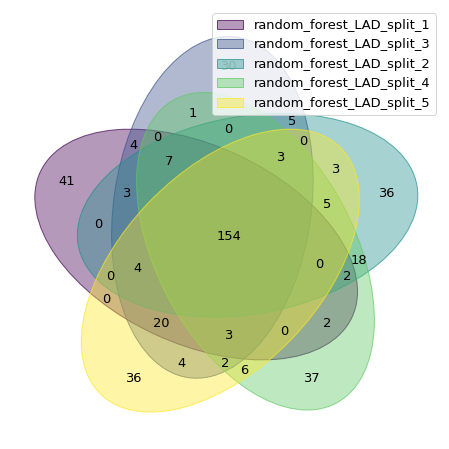

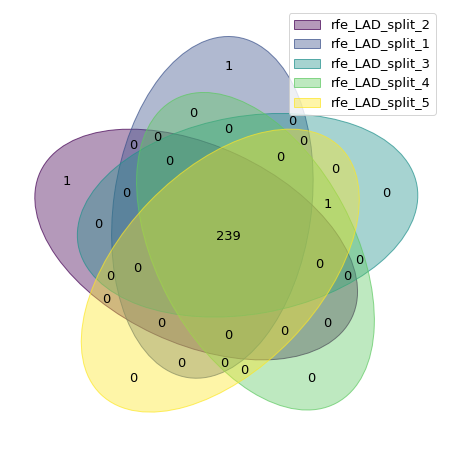

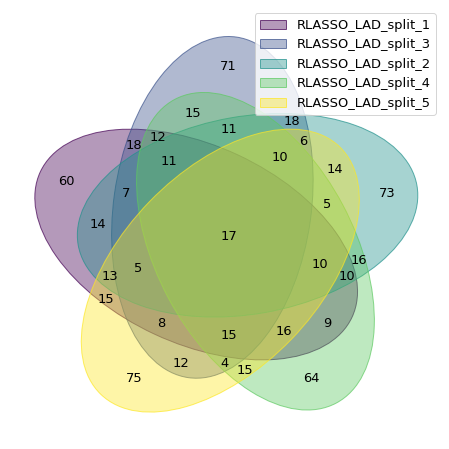

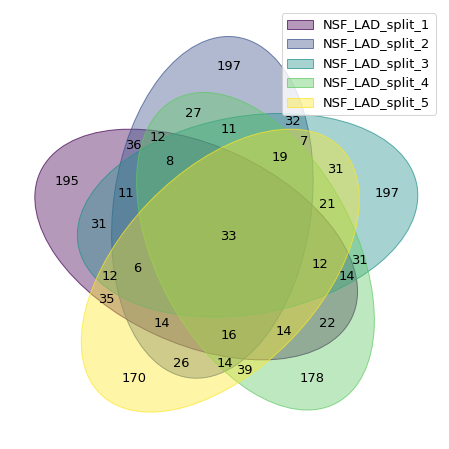

In [19]:
###############################################################################
# 80/20 holdout feature selection comparisons

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/LAD_labeled_b13_fixed.csv', 'r') as f:
  df_labeled_init_no_liver = pd.read_csv(f)

df_labeled_init_no_liver = df_labeled_init_no_liver.rename(columns={'sample_id': "Run"})

X = df_labeled_init_no_liver.drop(['Run', 'age', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

venn_dict_LASSO = {}
venn_dict_random_forest = {}
venn_dict_rfe = {}

for filename in os.listdir('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'):

  LASSO_set = set()
  random_forest_set = set()
  rfe_set = set()

  if 'top_240_indices_LAD' in filename:

    if 'LASSO' in filename:

      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          LASSO_set.add(gene)

        s = filename.split('_')
        venn_dict_LASSO['LASSO_LAD_split_'+s[-1][0]] = LASSO_set

    elif 'random_forest' in filename:

        with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:

          df_top80 = pd.read_csv(f, header=None)
        
          top80_list = df_top80[0].values.tolist()
          top80_list = [int(i) for i in top80_list]

          for index in top80_list:
            gene = X.columns[index]
            random_forest_set.add(gene)

          s = filename.split('_')
          venn_dict_random_forest['random_forest_LAD_split_'+s[-1][0]] = random_forest_set

    elif 'rfe' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          rfe_set.add(gene)

        s = filename.split('_')
        venn_dict_rfe['rfe_LAD_split_'+s[-1][0]] = rfe_set


split_1_NSF_set = set()
split_2_NSF_set = set()
split_3_NSF_set = set()
split_4_NSF_set = set()
split_5_NSF_set = set()

for filename in os.listdir('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'):
  
  if 'top_120_indices_LAD' in filename:
    if 'split_1' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_1_NSF_set.add(gene)

    if 'split_2' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_2_NSF_set.add(gene)

    if 'split_3' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_3_NSF_set.add(gene)

    if 'split_4' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_4_NSF_set.add(gene)

    if 'split_5' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_5_NSF_set.add(gene)

venn_dict_NSF = {
    "NSF_LAD_split_1": split_1_NSF_set,
    "NSF_LAD_split_2": split_2_NSF_set,
    "NSF_LAD_split_3": split_3_NSF_set,
    "NSF_LAD_split_4": split_4_NSF_set,
    "NSF_LAD_split_5": split_5_NSF_set
}


venn(venn_dict_random_forest)
venn(venn_dict_rfe)
venn(venn_dict_LASSO)
venn(venn_dict_NSF)


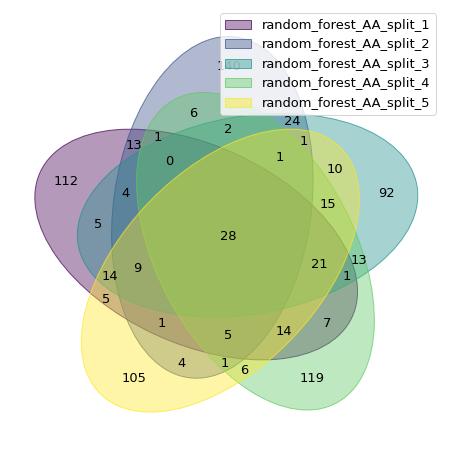

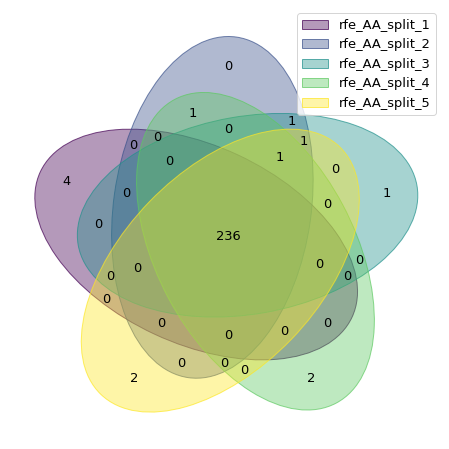

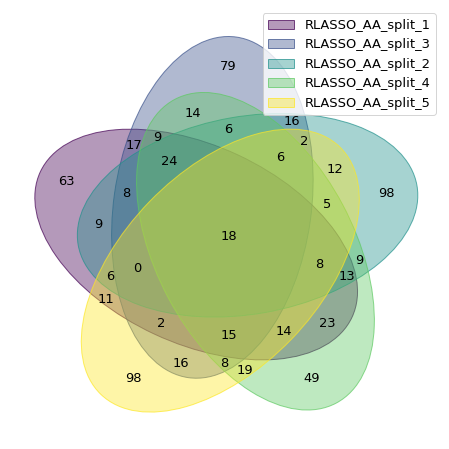

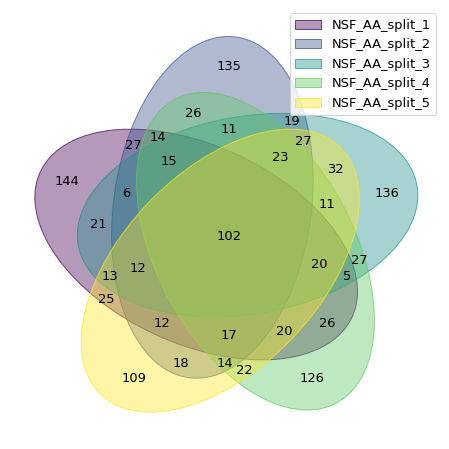

In [20]:
###############################################################################
# 80/20 holdout feature selection comparisons

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/AA_labeled_b13_fixed.csv', 'r') as f:
  df_labeled_init_no_liver = pd.read_csv(f)

df_labeled_init_no_liver = df_labeled_init_no_liver.rename(columns={'sample_id': "Run"})

X = df_labeled_init_no_liver.drop(['Run', 'age', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

venn_dict_LASSO = {}
venn_dict_random_forest = {}
venn_dict_rfe = {}

for filename in os.listdir('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'):

  LASSO_set = set()
  random_forest_set = set()
  rfe_set = set()

  if 'top_240_indices_AA' in filename:

    if 'LASSO' in filename:

      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          LASSO_set.add(gene)

        s = filename.split('_')
        venn_dict_LASSO['LASSO_AA_split_'+s[-1][0]] = LASSO_set

    elif 'random_forest' in filename:

        with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:

          df_top80 = pd.read_csv(f, header=None)
        
          top80_list = df_top80[0].values.tolist()
          top80_list = [int(i) for i in top80_list]

          for index in top80_list:
            gene = X.columns[index]
            random_forest_set.add(gene)

          s = filename.split('_')
          venn_dict_random_forest['random_forest_AA_split_'+s[-1][0]] = random_forest_set

    elif 'rfe' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          rfe_set.add(gene)

        s = filename.split('_')
        venn_dict_rfe['rfe_AA_split_'+s[-1][0]] = rfe_set


split_1_NSF_set = set()
split_2_NSF_set = set()
split_3_NSF_set = set()
split_4_NSF_set = set()
split_5_NSF_set = set()

for filename in os.listdir('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'):
  
  if 'top_120_indices_AA' in filename:
    if 'split_1' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_1_NSF_set.add(gene)

    if 'split_2' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_2_NSF_set.add(gene)

    if 'split_3' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_3_NSF_set.add(gene)

    if 'split_4' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_4_NSF_set.add(gene)

    if 'split_5' in filename:
      with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_feature_selections_results/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        for gene in top80_list:
          split_5_NSF_set.add(gene)

venn_dict_NSF = {
    "NSF_AA_split_1": split_1_NSF_set,
    "NSF_AA_split_2": split_2_NSF_set,
    "NSF_AA_split_3": split_3_NSF_set,
    "NSF_AA_split_4": split_4_NSF_set,
    "NSF_AA_split_5": split_5_NSF_set
}


venn(venn_dict_random_forest)
venn(venn_dict_rfe)
venn(venn_dict_LASSO)
venn(venn_dict_NSF)


In [24]:
# characterize per-split severity using 80/20 holdouts for each holdout

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/train_test_splits_AA_b13.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)


with pd.ExcelWriter('split_by_split.xlsx') as writer:

  for split in range(1,6):

    train_col = [col for col in train_test_splits.columns if str(split)+'_train' in col]
    train_indices = train_test_splits[train_col[0]].dropna().to_list()
    test_col = [col for col in train_test_splits.columns if str(split)+'_test' in col]
    test_indices = train_test_splits[test_col[0]].dropna().to_list()

    AA_confusion_table_model_this_split_train = AA_confusion_table_model.iloc[train_indices]

    AA_confusion_table_model_this_split_test = AA_confusion_table_model.iloc[test_indices]

    print(AA_confusion_table_model_this_split_train.shape)
    print(AA_confusion_table_model_this_split_test.shape)

    
    AA_confusion_table_model_this_split_train.to_excel(writer, sheet_name='AA_train_'+str(split))
    AA_confusion_table_model_this_split_test.to_excel(writer, sheet_name='AA_test_'+str(split))


(193, 27)
(49, 27)
(193, 27)
(49, 27)
(194, 27)
(48, 27)
(194, 27)
(48, 27)
(194, 27)
(48, 27)


In [11]:
###########################################################################################
# create excel sheets for holdout feature selection confusion matrix correlation analysis #
###########################################################################################

#######################################################################################################################
# Table analysis w/ gradings
#######################################################################################################################

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/confusion_matrix/GPAA_AA_b13_metadata_fixed.csv', 'r') as f:
  AA_metadata = pd.read_csv(f)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_confusion_matrix/holdout_NSF_XGB_confusion_AA.csv', 'r') as f:
  NSF_AA_results_holdout = pd.read_csv(f)
  NSF_AA_results_holdout = NSF_AA_results_holdout.to_records(index=False)
  NSF_AA_results_holdout = list(NSF_AA_results_holdout)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_confusion_matrix/holdout_random_forest_XGB_confusion_AA.csv', 'r') as f:
  random_forest_AA_results_holdout = pd.read_csv(f)
  random_forest_AA_results_holdout = random_forest_AA_results_holdout.to_records(index=False)
  random_forest_AA_results_holdout = list(random_forest_AA_results_holdout)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_confusion_matrix/holdout_RFE_XGB_confusion_AA.csv', 'r') as f:
  RFE_AA_results_holdout = pd.read_csv(f)
  RFE_AA_results_holdout = RFE_AA_results_holdout.to_records(index=False)
  RFE_AA_results_holdout = list(RFE_AA_results_holdout)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_confusion_matrix/holdout_LASSO_XGB_confusion_AA.csv', 'r') as f:
  LASSO_AA_results_holdout = pd.read_csv(f)
  LASSO_AA_results_holdout = LASSO_AA_results_holdout.to_records(index=False)
  LASSO_AA_results_holdout = list(LASSO_AA_results_holdout)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/holdout_confusion_matrix/holdout_union_XGB_confusion_AA.csv', 'r') as f:
  union_AA_results_holdout = pd.read_csv(f)
  union_AA_results_holdout = union_AA_results_holdout.to_records(index=False)
  union_AA_results_holdout = list(union_AA_results_holdout)

#########################################################################################################################

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_asr_rmhighcor_NSF_XGB_confusion_AA.csv', 'r') as f:
  NSF_AA_results_holdout_asr_rmhighcor = pd.read_csv(f)
  NSF_AA_results_holdout_asr_rmhighcor = NSF_AA_results_holdout_asr_rmhighcor.to_records(index=False)
  NSF_AA_results_holdout_asr_rmhighcor = list(NSF_AA_results_holdout_asr_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_asr_rmhighcor_random_forest_XGB_confusion_AA.csv', 'r') as f:
  random_forest_AA_results_holdout_asr_rmhighcor = pd.read_csv(f)
  random_forest_AA_results_holdout_asr_rmhighcor = random_forest_AA_results_holdout_asr_rmhighcor.to_records(index=False)
  random_forest_AA_results_holdout_asr_rmhighcor = list(random_forest_AA_results_holdout_asr_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_asr_rmhighcor_RFE_XGB_confusion_AA.csv', 'r') as f:
  RFE_AA_results_holdout_asr_rmhighcor = pd.read_csv(f)
  RFE_AA_results_holdout_asr_rmhighcor = RFE_AA_results_holdout_asr_rmhighcor.to_records(index=False)
  RFE_AA_results_holdout_asr_rmhighcor = list(RFE_AA_results_holdout_asr_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_asr_rmhighcor_LASSO_XGB_confusion_AA.csv', 'r') as f:
  LASSO_AA_results_holdout_asr_rmhighcor = pd.read_csv(f)
  LASSO_AA_results_holdout_asr_rmhighcor = LASSO_AA_results_holdout_asr_rmhighcor.to_records(index=False)
  LASSO_AA_results_holdout_asr_rmhighcor = list(LASSO_AA_results_holdout_asr_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_asr_rmhighcor_union_XGB_confusion_AA.csv', 'r') as f:
  union_AA_results_holdout_asr_rmhighcor = pd.read_csv(f)
  union_AA_results_holdout_asr_rmhighcor = union_AA_results_holdout_asr_rmhighcor.to_records(index=False)
  union_AA_results_holdout_asr_rmhighcor = list(union_AA_results_holdout_asr_rmhighcor)

#########################################################################################################################

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_noconfound_rmhighcor_NSF_XGB_confusion_AA.csv', 'r') as f:
  NSF_AA_results_holdout_noconfound_rmhighcor = pd.read_csv(f)
  NSF_AA_results_holdout_noconfound_rmhighcor = NSF_AA_results_holdout_noconfound_rmhighcor.to_records(index=False)
  NSF_AA_results_holdout_noconfound_rmhighcor = list(NSF_AA_results_holdout_noconfound_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_noconfound_rmhighcor_random_forest_XGB_confusion_AA.csv', 'r') as f:
  random_forest_AA_results_holdout_noconfound_rmhighcor = pd.read_csv(f)
  random_forest_AA_results_holdout_noconfound_rmhighcor = random_forest_AA_results_holdout_noconfound_rmhighcor.to_records(index=False)
  random_forest_AA_results_holdout_noconfound_rmhighcor = list(random_forest_AA_results_holdout_noconfound_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_noconfound_rmhighcor_RFE_XGB_confusion_AA.csv', 'r') as f:
  RFE_AA_results_holdout_noconfound_rmhighcor = pd.read_csv(f)
  RFE_AA_results_holdout_noconfound_rmhighcor = RFE_AA_results_holdout_noconfound_rmhighcor.to_records(index=False)
  RFE_AA_results_holdout_noconfound_rmhighcor = list(RFE_AA_results_holdout_noconfound_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_noconfound_rmhighcor_LASSO_XGB_confusion_AA.csv', 'r') as f:
  LASSO_AA_results_holdout_noconfound_rmhighcor = pd.read_csv(f)
  LASSO_AA_results_holdout_noconfound_rmhighcor = LASSO_AA_results_holdout_noconfound_rmhighcor.to_records(index=False)
  LASSO_AA_results_holdout_noconfound_rmhighcor = list(LASSO_AA_results_holdout_noconfound_rmhighcor)

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed_DE/holdout_confusion_matrix/holdout_noconfound_rmhighcor_union_XGB_confusion_AA.csv', 'r') as f:
  union_AA_results_holdout_noconfound_rmhighcor = pd.read_csv(f)
  union_AA_results_holdout_noconfound_rmhighcor = union_AA_results_holdout_noconfound_rmhighcor.to_records(index=False)
  union_AA_results_holdout_noconfound_rmhighcor = list(union_AA_results_holdout_noconfound_rmhighcor)

#########################################################################################################################

with open('/content/drive/My Drive/GPAA/AA_LAD_split_fixed/confusion_matrix/GPAA_samples_batches0-13_metadata_detail.csv', 'r') as f:
  sample_qualities = pd.read_csv(f)
  sample_qualities = sample_qualities[['sample_id', 'pathology', 'type', ' LESION PRESENT', 'Total Surface % ', ' Grade FS %', ' Grade FP %', ' Grade CO %', ' Grade CA %']]


#(sample_id, LESION PRESENT, Total Surface %, Grade FS %,	Grade FP %,	Grade CO %,	Grade CA %)
#create pheaux gradings
for index, row in sample_qualities.iterrows():
  if row['type'] == 'L':
    sample_qualities.at[index, 'Total Surface % '] = 100
    if row['pathology'] == 'fc':
      sample_qualities.at[index, ' Grade CA %'] = 100

    elif row['pathology'] == 'fp':
      sample_qualities.at[index, ' Grade FP %'] = 100

    elif row['pathology'] == 'fs':
      sample_qualities.at[index, ' Grade FS %'] = 100

  elif row['type'] == 'NL':
    sample_qualities.at[index, 'Total Surface % '] = 0

sample_qualities = sample_qualities[sample_qualities['type'] != 'liver']

sample_qualities['%_fs'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade FS %'] / 100, axis = 1)
sample_qualities['%_fc'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade CA %'] / 100, axis = 1)
sample_qualities['%_fp'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade FP %'] / 100, axis = 1)
sample_qualities['weighted_%_fp'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade FP %'] / 200, axis = 1) # 200 means weighting factor is .5
sample_qualities['%_co'] = sample_qualities.apply(lambda row: row['Total Surface % '] * row[' Grade CO %'] / 100, axis = 1)
sample_qualities['%_severity'] = sample_qualities['Total Surface % '] * sample_qualities[['%_fc', '%_fp', '%_co']].sum(axis=1) / 100
sample_qualities['%_severity_weighted_fp'] = sample_qualities['Total Surface % '] * sample_qualities[['%_fc', '%_co', 'weighted_%_fp']].sum(axis=1) / 100
sample_qualities = sample_qualities.fillna(0)
print(sample_qualities.shape)
print(sample_qualities['%_severity'])

(307, 16)
0      100.0
1        0.0
2      100.0
3        0.0
4      100.0
       ...  
330     25.0
331      0.0
332      0.0
333     25.0
334      0.0
Name: %_severity, Length: 307, dtype: float64


In [16]:
# initialize dataframe - each row is a sample. start with AA, keeping constant model across models
AA_confusion_table_model = pd.DataFrame(AA_metadata['sample_id'])

AA_confusion_table_model = AA_confusion_table_model.merge(sample_qualities[['sample_id','%_fs', '%_fc', '%_co', '%_fp', 'weighted_%_fp', '%_severity', '%_severity_weighted_fp']], on='sample_id')
print(AA_confusion_table_model.shape)
AA_confusion_table_model.head()

AA_confusion_table_model['union_TP'] = 0
AA_confusion_table_model['union_TN'] = 0
AA_confusion_table_model['union_FP'] = 0
AA_confusion_table_model['union_FN'] = 0
AA_confusion_table_model['LASSO_TP'] = 0
AA_confusion_table_model['LASSO_TN'] = 0
AA_confusion_table_model['LASSO_FP'] = 0
AA_confusion_table_model['LASSO_FN'] = 0
AA_confusion_table_model['rfe_TP'] = 0
AA_confusion_table_model['rfe_TN'] = 0
AA_confusion_table_model['rfe_FP'] = 0
AA_confusion_table_model['rfe_FN'] = 0
AA_confusion_table_model['random_forest_TP'] = 0
AA_confusion_table_model['random_forest_TN'] = 0
AA_confusion_table_model['random_forest_FP'] = 0
AA_confusion_table_model['random_forest_FN'] = 0
AA_confusion_table_model['NSF_TP'] = 0
AA_confusion_table_model['NSF_TN'] = 0
AA_confusion_table_model['NSF_FP'] = 0
AA_confusion_table_model['NSF_FN'] = 0

AA_confusion_table_model_holdout = AA_confusion_table_model.set_index('sample_id')
AA_confusion_table_model_holdout_asr_rmhighcor = AA_confusion_table_model.set_index('sample_id')
AA_confusion_table_model_holdout_noconfound_rmhighcor = AA_confusion_table_model.set_index('sample_id')

print(AA_confusion_table_model_holdout.shape)
AA_confusion_table_model_holdout.head()

(242, 8)
(242, 27)


,%_fs,%_fc,%_co,%_fp,weighted_%_fp,%_severity,%_severity_weighted_fp,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,0.0,100.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540-NL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540b-L,0.0,100.0,0.0,0.0,0.0,100.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1540b-NL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c1560-L,0.0,100.0,0.0,0.0,0.0,100.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
AA_results_holdout = [union_AA_results_holdout, LASSO_AA_results_holdout, RFE_AA_results_holdout, random_forest_AA_results_holdout, NSF_AA_results_holdout]

for result in AA_results_holdout:
  for record in result:
    col = ''
    if len(record[1].split('_')) == 2:
      model = record[1].split('_')[0]
    else:
      model = record[1].split('_')[0:2]
      model = "_".join(model)
    
    label = '_'+str(record[3])
    col = model+label

    AA_confusion_table_model_holdout.at[record[4], col] = AA_confusion_table_model_holdout.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_model_holdout.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_model_holdout.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_model_holdout.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_model_holdout.columns if 'FN' in col]

AA_confusion_table_model_holdout['TP_%'] = AA_confusion_table_model_holdout.apply(lambda row: sum(row[tp_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout['TN_%'] = AA_confusion_table_model_holdout.apply(lambda row: sum(row[tn_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout['FP_%'] = AA_confusion_table_model_holdout.apply(lambda row: sum(row[fp_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout['FN_%'] = AA_confusion_table_model_holdout.apply(lambda row: sum(row[fn_cols]) / 85, axis = 1)

AA_confusion_table_model_holdout = AA_confusion_table_model_holdout[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_model_holdout if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

print(AA_confusion_table_model_holdout.shape)
AA_confusion_table_model_holdout.head()

(242, 31)


,%_fs,%_fc,%_fp,%_co,TP_%,TN_%,FP_%,FN_%,weighted_%_fp,%_severity,%_severity_weighted_fp,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,0.976471,0.000000,0.000000,0.023529,0.0,100.0,100.0,17,0,0,0,16,0,0,1,16,0,0,1,17,0,0,0,17,0,0,0
c1540-NL,0.0,0.0,0.0,0.0,0.000000,0.941176,0.058824,0.000000,0.0,0.0,0.0,0,17,0,0,0,17,0,0,0,16,1,0,0,17,0,0,0,13,4,0
c1540b-L,0.0,100.0,0.0,0.0,0.376471,0.000000,0.000000,0.623529,0.0,100.0,100.0,16,0,0,1,12,0,0,5,1,0,0,16,2,0,0,15,1,0,0,16
c1540b-NL,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0
c1560-L,0.0,100.0,0.0,0.0,0.988235,0.000000,0.000000,0.011765,0.0,100.0,100.0,17,0,0,0,17,0,0,0,16,0,0,1,17,0,0,0,17,0,0,0


In [18]:
AA_results_holdout_asr_rmhighcor = [union_AA_results_holdout_asr_rmhighcor, LASSO_AA_results_holdout_asr_rmhighcor, RFE_AA_results_holdout_asr_rmhighcor, random_forest_AA_results_holdout_asr_rmhighcor, NSF_AA_results_holdout_asr_rmhighcor]

for result in AA_results_holdout_asr_rmhighcor:
  for record in result:
    col = ''
    if len(record[1].split('_')) == 2:
      model = record[1].split('_')[0]
    else:
      model = record[1].split('_')[0:2]
      model = "_".join(model)
    
    label = '_'+str(record[3])
    col = model+label

    AA_confusion_table_model_holdout_asr_rmhighcor.at[record[4], col] = AA_confusion_table_model_holdout_asr_rmhighcor.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_model_holdout_asr_rmhighcor.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_model_holdout_asr_rmhighcor.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_model_holdout_asr_rmhighcor.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_model_holdout_asr_rmhighcor.columns if 'FN' in col]

AA_confusion_table_model_holdout_asr_rmhighcor['TP_%'] = AA_confusion_table_model_holdout_asr_rmhighcor.apply(lambda row: sum(row[tp_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout_asr_rmhighcor['TN_%'] = AA_confusion_table_model_holdout_asr_rmhighcor.apply(lambda row: sum(row[tn_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout_asr_rmhighcor['FP_%'] = AA_confusion_table_model_holdout_asr_rmhighcor.apply(lambda row: sum(row[fp_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout_asr_rmhighcor['FN_%'] = AA_confusion_table_model_holdout_asr_rmhighcor.apply(lambda row: sum(row[fn_cols]) / 85, axis = 1)

AA_confusion_table_model_holdout_asr_rmhighcor = AA_confusion_table_model_holdout_asr_rmhighcor[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_model_holdout_asr_rmhighcor if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

print(AA_confusion_table_model_holdout_asr_rmhighcor.shape)
AA_confusion_table_model_holdout_asr_rmhighcor.head()

(242, 31)


,%_fs,%_fc,%_fp,%_co,TP_%,TN_%,FP_%,FN_%,weighted_%_fp,%_severity,%_severity_weighted_fp,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,0.964706,0.000000,0.000000,0.035294,0.0,100.0,100.0,17,0,0,0,16,0,0,1,17,0,0,0,17,0,0,0,15,0,0,2
c1540-NL,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0
c1540b-L,0.0,100.0,0.0,0.0,0.670588,0.000000,0.000000,0.329412,0.0,100.0,100.0,16,0,0,1,10,0,0,7,9,0,0,8,16,0,0,1,6,0,0,11
c1540b-NL,0.0,0.0,0.0,0.0,0.000000,0.988235,0.011765,0.000000,0.0,0.0,0.0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0,16,1,0
c1560-L,0.0,100.0,0.0,0.0,0.952941,0.000000,0.000000,0.047059,0.0,100.0,100.0,16,0,0,1,17,0,0,0,17,0,0,0,17,0,0,0,14,0,0,3


In [19]:
AA_results_holdout_noconfound_rmhighcor = [union_AA_results_holdout_noconfound_rmhighcor, LASSO_AA_results_holdout_noconfound_rmhighcor, RFE_AA_results_holdout_noconfound_rmhighcor, random_forest_AA_results_holdout_noconfound_rmhighcor, NSF_AA_results_holdout_noconfound_rmhighcor]

for result in AA_results_holdout_noconfound_rmhighcor:
  for record in result:
    col = ''
    if len(record[1].split('_')) == 2:
      model = record[1].split('_')[0]
    else:
      model = record[1].split('_')[0:2]
      model = "_".join(model)
    
    label = '_'+str(record[3])
    col = model+label

    AA_confusion_table_model_holdout_noconfound_rmhighcor.at[record[4], col] = AA_confusion_table_model_holdout_noconfound_rmhighcor.at[record[4], col] + 1

tp_cols = [col for col in AA_confusion_table_model_holdout_noconfound_rmhighcor.columns if 'TP' in col]
tn_cols = [col for col in AA_confusion_table_model_holdout_noconfound_rmhighcor.columns if 'TN' in col]
fp_cols = [col for col in AA_confusion_table_model_holdout_noconfound_rmhighcor.columns if 'FP' in col]
fn_cols = [col for col in AA_confusion_table_model_holdout_noconfound_rmhighcor.columns if 'FN' in col]

AA_confusion_table_model_holdout_noconfound_rmhighcor['TP_%'] = AA_confusion_table_model_holdout_noconfound_rmhighcor.apply(lambda row: sum(row[tp_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout_noconfound_rmhighcor['TN_%'] = AA_confusion_table_model_holdout_noconfound_rmhighcor.apply(lambda row: sum(row[tn_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout_noconfound_rmhighcor['FP_%'] = AA_confusion_table_model_holdout_noconfound_rmhighcor.apply(lambda row: sum(row[fp_cols]) / 85, axis = 1)
AA_confusion_table_model_holdout_noconfound_rmhighcor['FN_%'] = AA_confusion_table_model_holdout_noconfound_rmhighcor.apply(lambda row: sum(row[fn_cols]) / 85, axis = 1)

AA_confusion_table_model_holdout_noconfound_rmhighcor = AA_confusion_table_model_holdout_noconfound_rmhighcor[['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%'] + [c for c in AA_confusion_table_model_holdout_noconfound_rmhighcor if c not in ['%_fs', '%_fc', '%_fp', '%_co', 'TP_%', 'TN_%', 'FP_%', 'FN_%']]]

print(AA_confusion_table_model_holdout_noconfound_rmhighcor.shape)
AA_confusion_table_model_holdout_noconfound_rmhighcor.head()

(242, 31)


,%_fs,%_fc,%_fp,%_co,TP_%,TN_%,FP_%,FN_%,weighted_%_fp,%_severity,%_severity_weighted_fp,union_TP,union_TN,union_FP,union_FN,RLASSO_TP,RLASSO_TN,RLASSO_FP,RLASSO_FN,rfe_TP,rfe_TN,rfe_FP,rfe_FN,random_forest_TP,random_forest_TN,random_forest_FP,random_forest_FN,NSF_TP,NSF_TN,NSF_FP,NSF_FN
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c1540-L,0.0,100.0,0.0,0.0,0.988235,0.000000,0.000000,0.011765,0.0,100.0,100.0,17,0,0,0,16,0,0,1,17,0,0,0,17,0,0,0,17,0,0,0
c1540-NL,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0
c1540b-L,0.0,100.0,0.0,0.0,0.611765,0.000000,0.000000,0.388235,0.0,100.0,100.0,10,0,0,7,10,0,0,7,9,0,0,8,12,0,0,5,11,0,0,6
c1540b-NL,0.0,0.0,0.0,0.0,0.000000,0.976471,0.023529,0.000000,0.0,0.0,0.0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0,15,2,0
c1560-L,0.0,100.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0,100.0,100.0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0,17,0,0,0


In [22]:
with pd.ExcelWriter('confusion_matrix_results_holdouts.xlsx') as writer:
  AA_confusion_table_model_holdout_noconfound_rmhighcor.to_excel(writer, sheet_name='AA_noconfound_rmhighcor_DE')
  AA_confusion_table_model_holdout_asr_rmhighcor.to_excel(writer, sheet_name='AA_asr_rmhighcor_DE')
  AA_confusion_table_model_holdout.to_excel(writer, sheet_name='AA_holdout')